In [2]:
!pip install tensorflow
!pip install keras
!pip install scikeras
!pip install xgboost
!pip install imblearn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from scikeras.wrappers import KerasRegressor
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
import xgboost as xgb

2024-12-10 02:40:50.634032: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 02:40:50.947438: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 02:40:51.088412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733798451.414739   50863 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733798451.495080   50863 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 02:40:52.165964: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [4]:
data = pd.read_csv('./cleaned_data_2.csv')

In [5]:
X = data.drop('readmitted', axis=1)
y = data['readmitted']

#TRUE/FALSE becomes 1/0
X = X.replace({'TRUE': 1, 'FALSE': 0})

In [6]:
# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Apply Label Encoding to categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

In [7]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# SMOTE to handle imbalanced samples
X_train_resampled, X_test, y_train_resampled, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

In [8]:
# Design the autoencoder
input_dimension = X_train_resampled.shape[1]
encoding_dimension = input_dimension // 2  

# Autoencoder architecture
input_layer = Input(shape=(input_dimension,))

encoder = Dense(input_dimension, activation='relu')(input_layer)
encoder = BatchNormalization()(encoder)
encoder = Dropout(0.2)(encoder)
encoder = Dense(encoding_dimension, activation='relu')(encoder)

latent_space = Dense(encoding_dimension // 2, activation='relu')(encoder)

decoder = Dense(encoding_dimension, activation='relu')(latent_space)
decoder = BatchNormalization()(decoder)
encoder = Dropout(0.2)(decoder)
decoder = Dense(input_dimension, activation='linear')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# Training autoencoder with early stopping mechanism
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
autoencoder.fit(
    X_train_resampled, X_train_resampled,
    epochs=50,
    batch_size=64,
    shuffle=True,
    callbacks=[early_stop],
    validation_data=(X_test, X_test)
)

# encoded features are extracted
encoder_model = Model(inputs=input_layer, outputs=encoder)
X_train_encoded = encoder_model.predict(X_train_resampled)
X_test_encoded = encoder_model.predict(X_test)

2024-12-10 02:40:59.064552: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/50


2024-12-10 02:40:59.321553: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 39692328 exceeds 10% of free system memory.
2024-12-10 02:40:59.387226: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 39692328 exceeds 10% of free system memory.


1988/1988 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 4487.9595 - val_loss: 4328.9502
Epoch 2/50
1988/1988 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4328.6504 - val_loss: 4080.3462
Epoch 3/50
1988/1988 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4061.4771 - val_loss: 3760.1060
Epoch 4/50
1988/1988 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3706.9031 - val_loss: 3392.0605
Epoch 5/50
1988/1988 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3331.1201 - val_loss: 3010.6025
Epoch 6/50
1988/1988 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2926.0562 - val_loss: 2586.3796
Epoch 7/50
1988/1988 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2510.3767 - val_loss: 2200.6230
Epoch 8/50
1988/1988 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2100.3904 - val_loss: 1794.4165
Epoch 9/50
1988/1988 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1704.0015 - val_loss: 1414.3877
Epoch 10/50
1988/1988 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1338.5172 - val_loss: 1055.5881
Epoch 11/50
1988/1988 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 994.494

2024-12-10 02:44:25.256937: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 39692328 exceeds 10% of free system memory.


3976/3976 ━━━━━━━━━━━━━━━━━━━━ 3s 756us/step
994/994 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step


In [1]:
#Large and Thought Out Grid Search
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [6, 8, 10],
#     'learning_rate': [0.1, 0.2, 0.3, 0.5],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
# }

#Results that we got
param_grid = {
    'n_estimators': [300],
    'max_depth': [10],
    'learning_rate': [0.3],
    'subsample': [0.8],
    'colsample_bytree': [1.0],
}

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss'
)

NameError: name 'xgb' is not defined

In [ ]:
warnings.filterwarnings("ignore", message=".*Parameters.*")

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_encoded, y_train_resampled)

# Best model
best_xgb = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Parameters from Grid Search:")
print(best_params)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [ ]:
y_pred = best_xgb.predict(X_test_encoded)
y_pred_proba = best_xgb.predict_proba(X_test_encoded)[:, 1]

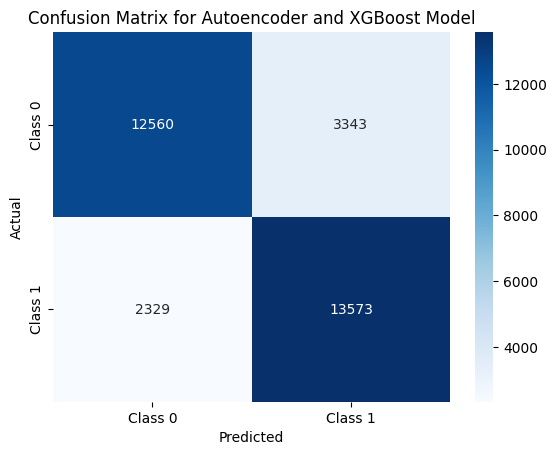

Accuracy: 0.82
Precision: 0.80
Recall: 0.85
F1-Score: 0.83
AUC-ROC: 0.89


In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title(f"Confusion Matrix for Autoencoder and XGBoost Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

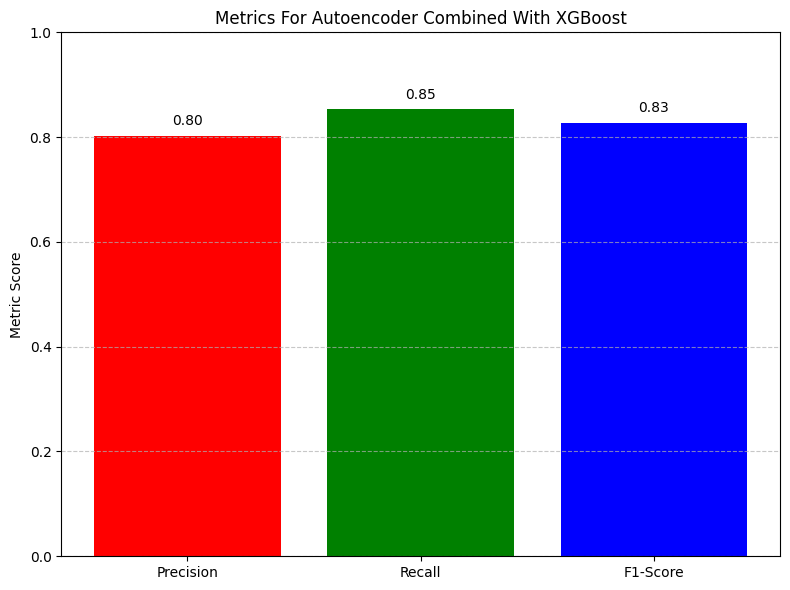

In [ ]:
metrics = ['Precision', 'Recall', 'F1-Score']
values = [precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['red', 'green', 'blue'])

plt.ylabel('Metric Score')
plt.title('Metrics For Autoencoder Combined With XGBoost')
plt.ylim(0, 1)  
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, value in enumerate(values):
    plt.text(i, value + 0.02, f"{value:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [59]:
!pip install shap --upgrade
!pip install lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.9/543.9 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 51.1 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 48.8 MB/s eta 0:00:00:00:01
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=96747ac1232d90b91dc31c96874a3cbcedddc1874ba62a77a7af4b1b91dfece9
  Stored in directory: /home/codespace/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer

explainer = shap.Explainer(best_xgb, X_train_encoded)
shap_values = explainer(X_test_encoded)
shap.summary_plot(shap_values, X_test_encoded, feature_names=X.columns)

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'best_xgb' is not defined

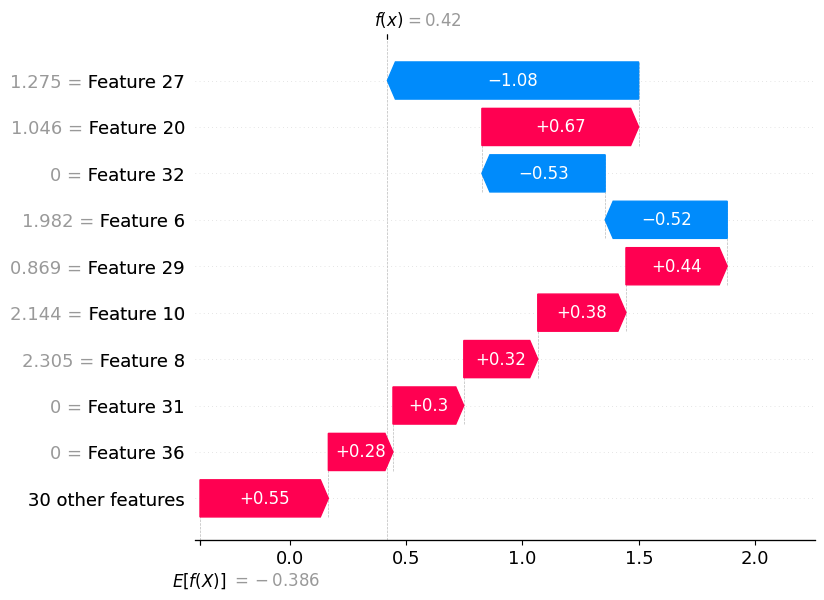

In [34]:
single_index = 0 
shap.waterfall_plot(shap_values[single_index])

lime_explainer = LimeTabularExplainer(
    training_data=X_train_encoded,
    feature_names=X.columns.tolist(), 
    class_names=["Not Readmitted", "Readmitted"],
    mode='classification'
)

instance_to_explain = X_test_encoded[single_index] 

lime_exp = lime_explainer.explain_instance(
    data_row=instance_to_explain,
    predict_fn=best_xgb.predict_proba
)

lime_exp.show_in_notebook()